# Problem Sheet 3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

## AIC for Linear Models

For the first problem in problem sheet 3, we are asked to derive the AIC (Akaike Information Criterion) expression for the linear model 

$$
    {\bf y} \sim \mathcal{N}_N({\bf X}\boldsymbol\beta, \sigma^2{\bf I})
$$

Recalling that the AIC is defined as:

$$
    \text{AIC} = 2k - 2\log\hat{\mathcal{L}}
$$

Where $k$ is the number of parameters and $\hat{\mathcal{L}}$ is the likelihood function evaluated at its maximum value, we see that the AIC takes the form

$$
\begin{aligned}
    \text{AIC} 
    &= 2k - N\log(2\pi\sigma^2) + \sigma^{-2}{\bf y}^T({\bf y} - {\bf X}({\bf X}^T {\bf X})^{-1} {\bf X}^T {\bf y})\\
    &= 2k - N\log(2\pi\sigma^2) + \sigma^{-2}{\bf y}^T({\bf y} - {\bf X}\hat{\boldsymbol \beta})\\
    &= 2k - N\log(2\pi\sigma^2) + \sigma^{-2}{\bf y}^T({\bf y} - \hat{\bf y})\\
\end{aligned}
$$


In [3]:
## An example ##
np.random.seed(314)
n_obs = 40
sigma2 = 0.7
beta = np.array([0.3, 1.3, -2.3, -1.5])
x = np.linspace(-2.1, 1.6, n_obs) + 2 * (np.random.rand(n_obs) - 1) / 10
# The true Basis function 
Phi = np.array([x ** 0, x ** 1, x ** 2, x ** 3])

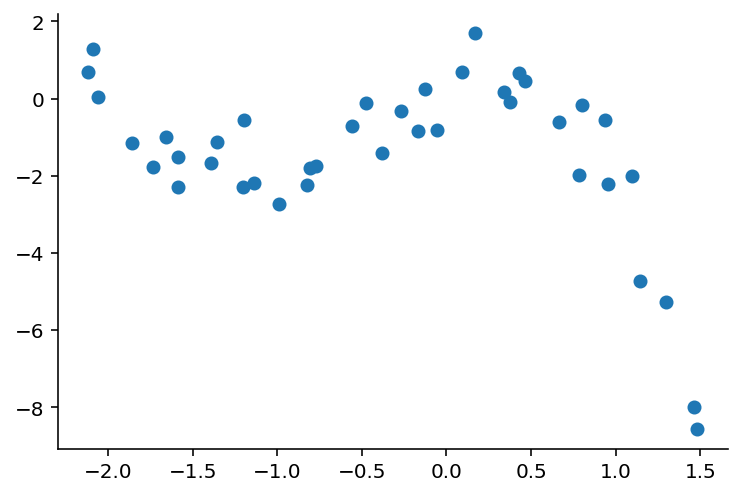

In [4]:
y = np.einsum("m,mn->n", beta, Phi) + np.random.randn(n_obs) * np.sqrt(sigma2)
plt.scatter(x, y)

In [5]:
def aic(y, yhat, k, sigma2):
    N = len(y)
    AIC = 2 * k - N * np.log(2 * np.pi * sigma2) + np.sum(y * (y - yhat)) / sigma2
    return AIC

def create_feature_matrix(x, p=1):
    X = [x ** pi for pi in range(p + 1)]
    X = np.array(X)
    return X.T


def fit_regression(X, y):
    beta_hat = inv(X.T @ X) @ X.T  @ y
    return beta_hat

In [6]:
poly_values = np.arange(6)

xtest = np.linspace(-2, 1.5, 100)

estimations_list = []
aic_list = [] 
for p in poly_values:
    X = create_feature_matrix(x, p=p)
    beta_hat = fit_regression(X, y)
    y_hat = np.einsum("nm,m->n", X, beta_hat)
    aic_value = aic(y, y_hat, p, sigma2)
    aic_list.append(aic_value)
    
    X_test = create_feature_matrix(xtest, p=p)
    y_test = np.einsum("nm,m->n", X_test, beta_hat)
    estimations_list.append(y_test)

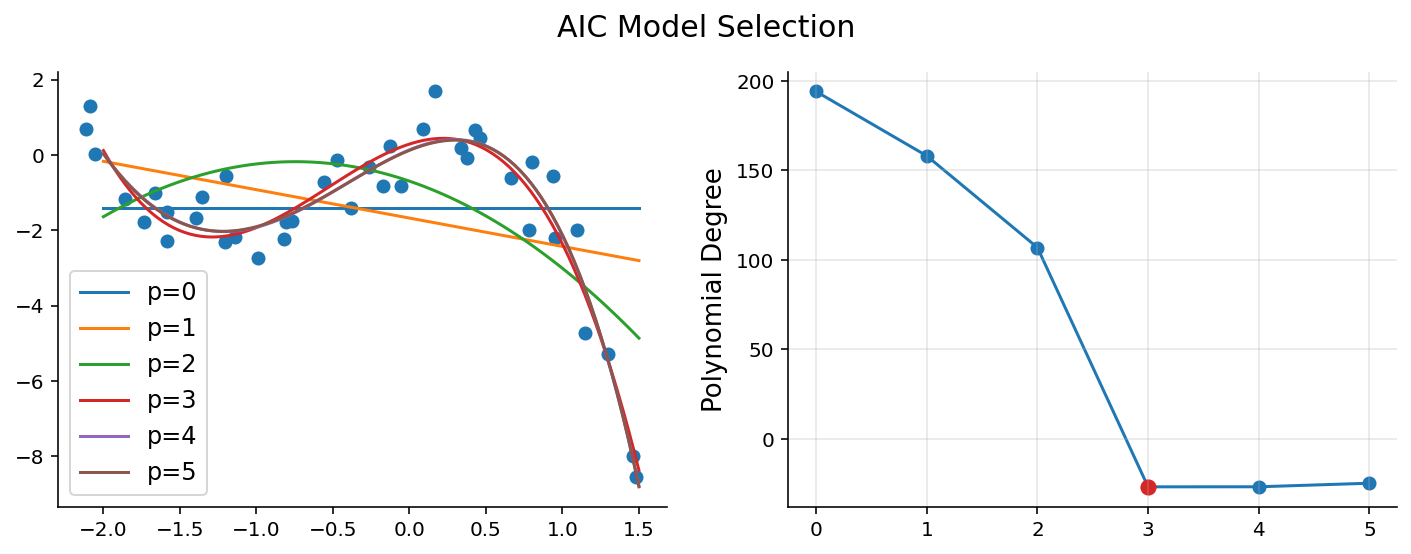

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))


ax[0].scatter(x, y)
for p, ytest in zip(poly_values, estimations_list):
    ax[0].plot(xtest, ytest, label=f"p={p}")
ax[0].legend(fontsize=12)



ax[1].plot(poly_values, aic_list, marker="o", zorder=-1)
ax[1].set_ylabel("AIC", fontsize=13)
ax[1].set_ylabel("Polynomial Degree", fontsize=13)
ax[1].grid(alpha=0.3)

p_best = np.argmin(aic_list)
ax[1].scatter(poly_values[p_best], aic_list[p_best], s=50, c="tab:red", zorder=1)


plt.suptitle("AIC Model Selection", fontsize=15);

For the linear model with polynomial basis functions, given an extra degree, the improvement is justified by the AIC if the marginal reduction in the term ${\bf y}^T({\bf y} - \hat{\bf y})$ is greater than $2$.

---

## Local Polynomials as a linear model

Let $\mathcal{D} = \{(x_n, y_n)\vert x_n\in\mathbb{R}, y_n\in\mathbb{R}\}_{n=1}^N$ be a dataset of observations such that

$$
    \forall n. y_n = f(x_n) + \epsilon_n
$$

where $f$ is an unkonwn function and $\{\epsilon_n\}_n$ are i.i.d errors with $0$ mean and variace $\sigma^2$. To approximate $f$, we make use of local polynomials by defining a function

$$
    \hat f(x) = \hat\beta_0(x) + \sum_{p=1}^P \beta_p(x)x^p
$$

and find the coefficients $\{\hat\beta_p(x)\}_{p=1}^P$ by reducing a weighted version of the RSS given by

$$
\{\hat\beta_p(x)\}_{p=1}^P = \arg\min_{\beta_0, \ldots, \beta_P} \sum_{n=1}^N K\left(\frac{x - x_n}{h}\right)\left(y_n - \sum_{p=0}^P\beta_p x_n^P\right)^2
$$


Where $K:\mathbb{R}\to\mathbb{R}$ is a kernel function with the following properties
* $\int K(x) dx = 1$
* $\int  x K(x) dx = 0$
* $0 < \int x^2 K(x) dx < +\infty$

---

For each point $x$, the problem has the explicit solution

$$
    \hat{\boldsymbol{\beta}}(x) = ({\bf B}^T\Omega{\bf B})^{-1}{\bf B}^T\Omega {\bf Y}
$$

With

$$
    \Omega = \text{diag}\left(K\left(\frac{x - x_1}{h}\right), \ldots, K\left(\frac{x - x_N}{h}\right) \right)
$$


$$
{\bf B} = \begin{bmatrix}
    x_1^0 & x_1^1 & \ldots & x_1^P \\
    \vdots & \ddots & \ldots & \vdots \\
    x_N^0 & x_N^1 & \ldots & x_N^P \\
\end{bmatrix}
$$

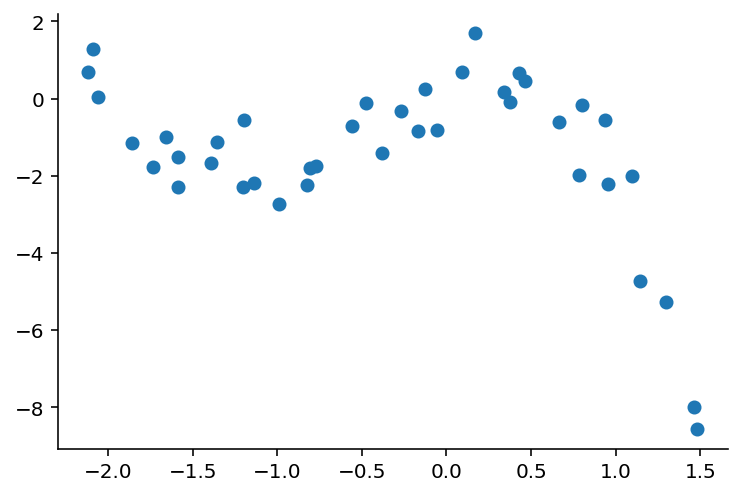

In [8]:
# In this example, we will be working with the 
# same dataset defined above
plt.scatter(x, y);

In [9]:
def build_B(x, deg):
    """
    Build matrix B
    
    Parameters
    ----------
    x: np.array(N)
        Unidimensional array of observations
    deg: int
        Degree of the polynomial
    """
    deg += 1
    return x[:, None] ** np.arange(deg)[None, :]


def gaussian_kernel(x, h):
    """
    Defines a Gaussian kernel
    
    Parameters
    ----------
    x: float
        Kernel evaluation point
    h: float
        Standard deviation of the component
    """
    kval = np.exp(-x ** 2 / (2 * h ** 2)) / (2 * np.pi * h) ** 2
    return kval


def fit_parameters_lp(x, X, y, h, p):
    """
    Find the β parameters for defining a
    local polynomial
    
    Parameters
    ----------
    x: np.array(Ntest)
        values to estimate y-values
    X: np.array(Ntrain)
        Observed independent training values
    y: np.array(Ntrain)
        Observed dependent training values
    h: float
        Tuning parameter
    p: int
        Polynomial degree to model
    """
    B = build_B(X, p)
    omega = gaussian_kernel(x[:, None] - X[None, :], h)
    beta_hat = inv(np.einsum("nm,kn,nl->kml", B, omega, B))
    beta_hat = np.einsum("kml,nl,kn,n->km", beta_hat, B, omega, y)
    return beta_hat


def local_polynomial(x, X, y, h, p):
    beta_hat = fit_parameters_lp(x, X, y, h, p)
    B_test = build_B(x, p)
    yhat = np.einsum("nm,nm->n", B_test, beta_hat)
    
    return yhat

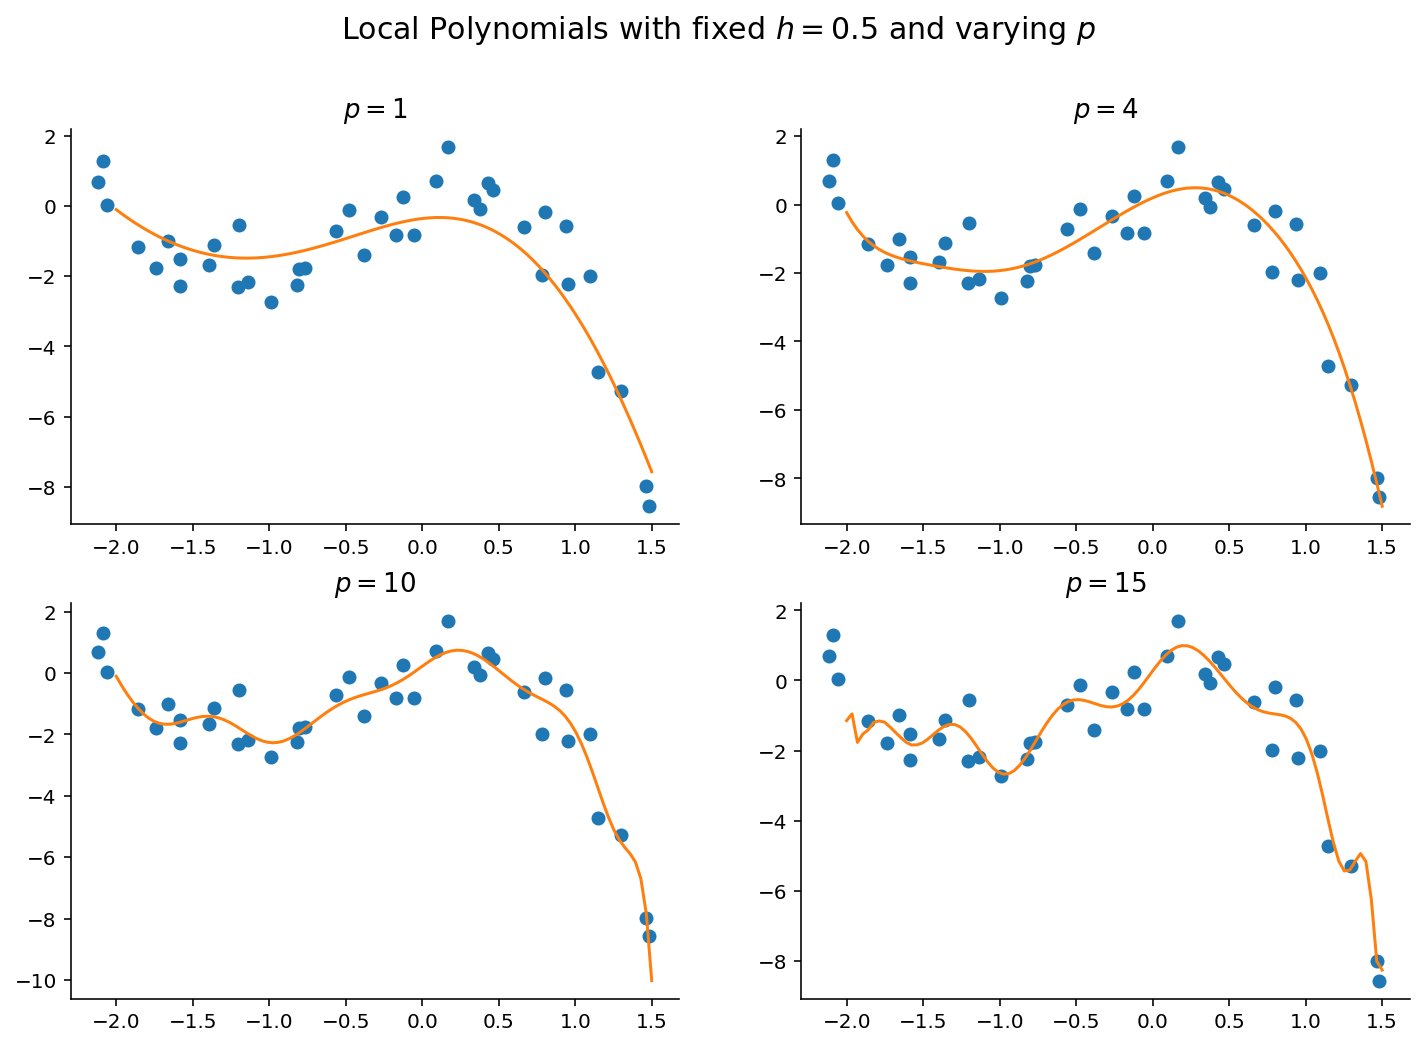

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax = ax.ravel()

h = 0.5
poly_deg = [1, 4, 10, 15]
for p, axi in zip(poly_deg, ax):
    ytest = local_polynomial(xtest, x, y, h, p)
    axi.plot(xtest, ytest, c="tab:orange")
    axi.scatter(x, y);
    axi.set_title(f"$p={p}$", fontsize=13)

title = f"Local Polynomials with fixed $h={h}$ and varying $p$"
plt.suptitle(title, fontsize=15);

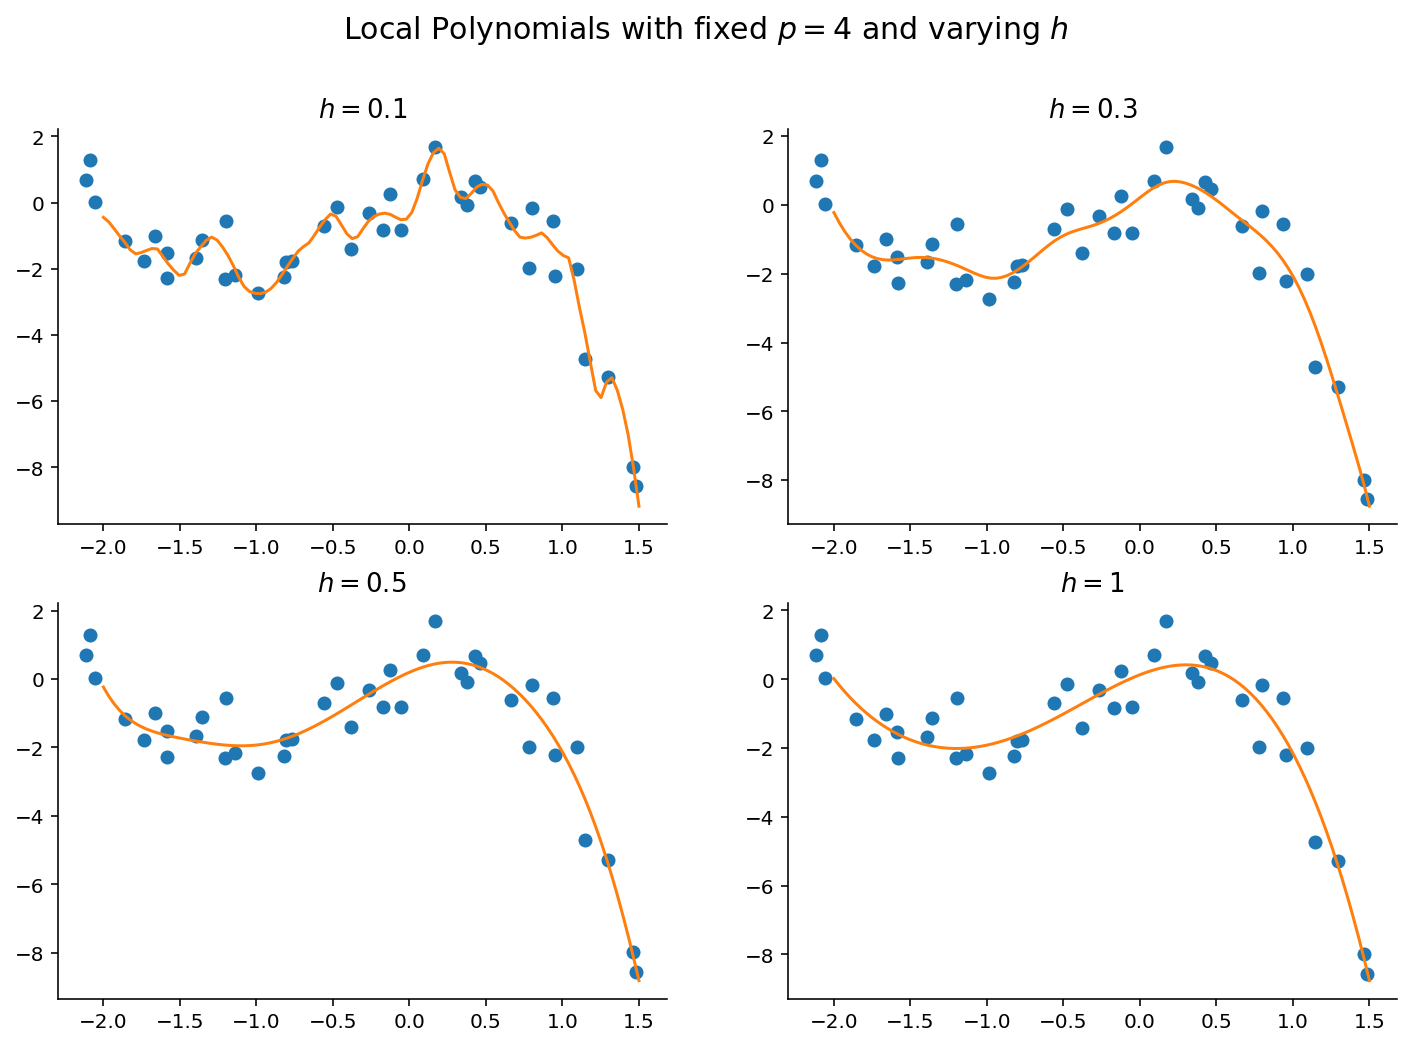

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax = ax.ravel()

p = 4
h_values = [0.1, 0.3, 0.5, 1]
for h, axi in zip(h_values, ax):
    ytest = local_polynomial(xtest, x, y, h, p)
    axi.plot(xtest, ytest, c="tab:orange")
    axi.scatter(x, y);
    axi.set_title(f"$h={h}$", fontsize=13)

title = f"Local Polynomials with fixed $p={p}$ and varying $h$"
plt.suptitle(title, fontsize=15);

-----

## LOOCV for a Linear Model


$$
    \hat{\boldsymbol\beta} - \hat{\boldsymbol\beta}^{(-j)} = \left(\frac{y_j - \hat y_j}{1 - H_{jj}}\right) ({\bf X}^T{\bf X})^{-1} {\bf x}_j^T
$$

Where
* $\hat{\boldsymbol\beta} = \left({\bf X}^T{\bf X}\right)^{-1}{\bf X}^T {\bf y}$
* $\hat{\boldsymbol\beta}^{(-j)}$ is the set of coefficients for the linear model without the $j$-th observation
* $H = {\bf X}\left({\bf X}^T{\bf X}\right)^{-1}{\bf X}^T$

In [12]:
X = Phi.T

### A numerical example

In [13]:
G = inv(np.einsum("nm,nk->mk", X, X))
beta_hat = np.einsum("mk,nk,n->m", G, X, y)
H_jj = np.einsum("nm,ml,nl->n", X, G, X)

In [14]:
j = 5
X_less_j = np.delete(X, j, axis=0)
y_less_j = np.delete(y, j, axis=0)

G_less_j = inv(np.einsum("nm,nk->mk", X_less_j, X_less_j))
beta_hat_less_j = np.einsum("mk,nk,n->m", G_less_j, X_less_j, y_less_j)

In [15]:
beta_hat - beta_hat_less_j

array([-0.00376271, -0.02545669,  0.01597928,  0.00718251])

In [16]:
(y[j] - X[j] @ beta_hat) / (1 - H_jj[j]) * G @ X[j]

array([-0.00376271, -0.02545669,  0.01597928,  0.00718251])

## An (small) einsum speedtest

In [17]:
Nv, Mv = 10_000, 5_000
V = np.random.randn(Nv, Mv)
GV = inv(V.T @ V)

In [18]:
%%time
HV1 = np.einsum("nm,ml,nl->n", V, GV, V, optimize=True)

CPU times: user 13.6 s, sys: 244 ms, total: 13.8 s
Wall time: 3.99 s


In [19]:
%%time
HV2 = np.diag(V @ GV @ V.T)

CPU times: user 47.4 s, sys: 1.64 s, total: 49 s
Wall time: 12.6 s
